In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, Sequence

from scipy import misc, ndimage
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread
from skimage.transform import resize

import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
cwd = os.getcwd()
print(cwd)

%matplotlib inline 

C:\Users\Lyokoheros\KCK\RecaptchaSolver\RecaptchaSolver


In [6]:
#przygotowanie danych w pamięci


train_dir = cwd + '/dane/train'
validation_dir = cwd + '/dane/validation'
dest_dir = cwd +'/dane/all'
counter = 0

for subdir, dirs, files in os.walk(train_dir):
    #print(files)
    for file in files:
        full_path = os.path.join(subdir, file)
        shutil.copy(full_path, dest_dir)
        counter = counter + 1
print(counter)

subdirs, dirs, files = os.walk(dest_dir).__next__()
m = len(files)
print(m)

filenames = []
labels = np.zeros((m, 1))


images_dir = dest_dir
filenames_counter = 0
labels_counter = -1

for subdir, dirs, files in os.walk(train_dir):
    #print(files)
    for file in files:
        filenames.append(file)
        labels[filenames_counter, 0] = labels_counter
        filenames_counter = filenames_counter + 1
    labels_counter = labels_counter+1
    
print(len(filenames))
print(labels.shape)

# saving the filename array as .npy file
np.save('filenames.npy', filenames)


# One hot vector representation of labels
y_labels_one_hot = to_categorical(labels)

# saving the y_labels_one_hot array as a .npy file
np.save('y_labels_one_hot.npy', y_labels_one_hot)

filenames_shuffled, y_labels_one_hot_shuffled = shuffle(filenames, y_labels_one_hot)

# saving the shuffled file.
# you can load them later using np.load().
np.save('y_labels_one_hot_shuffled.npy', y_labels_one_hot_shuffled)
np.save('filenames_shuffled.npy', filenames_shuffled)

filenames_shuffled_numpy = np.array(filenames_shuffled)

X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(
    filenames_shuffled_numpy, y_labels_one_hot_shuffled, test_size=0.2, random_state=1)

print(X_train_filenames.shape) # (3800,)
print(y_train.shape)           # (3800, 12)
total_train=X_train_filenames.shape[0]

print(X_val_filenames.shape)   # (950,)
print(y_val.shape)             # (950, 12)
total_val=X_val_filenames.shape[0]
print("próbek:", total_train, total_val)

# You can save these files as well. As you will be using them later for training and validation of your model.
np.save('X_train_filenames.npy', X_train_filenames)
np.save('y_train.npy', y_train)

np.save('X_val_filenames.npy', X_val_filenames)
np.save('y_val.npy', y_val)




1200
1200
1200
(1200, 1)
(960,)
(960, 2)
(240,)
(240, 2)
próbek: 960 240


In [10]:
#generator do danych
class My_Custom_Generator(tf.keras.utils.Sequence):
    
    
    
    def __init__(self, image_filenames, labels, batch_size, images_dir) :
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.images_dir = images_dir
    
    
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
        return np.array([
            resize(imread(os.path.join(images_dir, str(file_name))), (IMG_SIZE, IMG_SIZE, 3))
               for file_name in batch_x])/255.0, np.array(batch_y)

batch_size = 32
epochs = 10
IMG_SIZE = 126


my_training_batch_generator = My_Custom_Generator(X_train_filenames, y_train, batch_size, images_dir)
my_validation_batch_generator = My_Custom_Generator(X_val_filenames, y_val, batch_size, images_dir)

In [6]:
#przygotowanie modelu sieci
model = Sequential([
    Conv2D(filters = 64, kernel_size = (5,5), activation ='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)),
    BatchNormalization(axis=3),
    Conv2D(filters = 64, kernel_size = (5,5), activation ='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(axis=3),
    Dropout(0.5),
    
    Conv2D(filters = 128, kernel_size = (5,5), activation ='relu'),
    BatchNormalization(axis=3),
    Conv2D(filters = 128, kernel_size = (5,5), activation ='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(axis=3),
    Dropout(0.5),

    Conv2D(filters = 256, kernel_size = (5,5), activation ='relu'),
    BatchNormalization(axis=3),
    Conv2D(filters = 256, kernel_size = (5,5), activation ='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(axis=3),
    Dropout(0.5),

    Flatten(),

    Dense(256, activation = "relu"), #Fully connected layer
    BatchNormalization(),
    Dropout(0.5),

    Dense(60, activation = "relu"), #Fully connected layer
    BatchNormalization(),
    Dropout(0.5),

    Dense(4, activation = "softmax") #Classification layer or output layer 
])

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])


#model = Sequential([
#    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
#    MaxPooling2D(),
#    Conv2D(32, 3, padding='same', activation='relu'),
#    MaxPooling2D(),
#    Conv2D(64, 3, padding='same', activation='relu'),
#    MaxPooling2D(),
#    Flatten(),
#    Dense(32, activation='relu'),
#    Dense(1, activation='sigmoid')
#])

#model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 122, 122, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 122, 122, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 118, 118, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 59, 59, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 128)       2

In [7]:
#trenowanie


history = model.fit_generator(generator=my_training_batch_generator,
                   steps_per_epoch = int(total_train// batch_size),
                   epochs = 1,
                   verbose = 1,
                   validation_data = my_validation_batch_generator,
                   validation_steps = int(total_val// batch_size)
                             )

Epoch 1/10
16/16 [==============================] - 286s 18s/step - loss: 0.9143 - accuracy: 0.6739 - val_loss: 1.3775 - val_accuracy: 0.6406
Epoch 2/10
16/16 [==============================] - 245s 15s/step - loss: 0.7360 - accuracy: 0.6925 - val_loss: 3.1966 - val_accuracy: 0.6406
Epoch 3/10
16/16 [==============================] - 291s 18s/step - loss: 0.7556 - accuracy: 0.7107 - val_loss: 4.2480 - val_accuracy: 0.6406
Epoch 4/10
16/16 [==============================] - 287s 18s/step - loss: 0.6774 - accuracy: 0.7189 - val_loss: 3.2649 - val_accuracy: 0.6406
Epoch 5/10
16/16 [==============================] - 281s 18s/step - loss: 0.6095 - accuracy: 0.7412 - val_loss: 3.1557 - val_accuracy: 0.6406
Epoch 6/10
16/16 [==============================] - 280s 17s/step - loss: 0.6036 - accuracy: 0.7314 - val_loss: 2.5393 - val_accuracy: 0.6406
Epoch 7/10
16/16 [==============================] - 240s 15s/step - loss: 0.5688 - accuracy: 0.7599 - val_loss: 2.3412 - val_accuracy: 0.6406
Epoch 

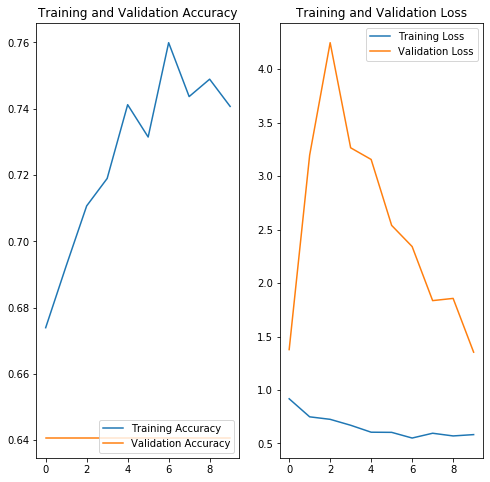

In [8]:
#Podsumowanie wyników

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
#test danych
sample_training_images, _ = next(my_training_batch_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes) :
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    
plotImages(sample_training_images[:5])

TypeError: 'My_Custom_Generator' object is not an iterator

In [8]:
L=[1, 2, 3, 1]
len(L)

4